#### AWS

Include the analysis script and setup the folders with raw data

We used a 10G connection instance 

Zone: eu-west-1a, instance type p3.2xlarge = 

- 1	GPUs - Tesla V100
- N/A	GPU Peer to Peer
- 16	GPU Memory (GB)
- 8	vCPUs
- 61	Memory (GB)
- Up to 10 Gbps Network Bandwidth	
- 1.5 Gbps EBS Bandwidth


boto3 endpoint = http://s3.amazonaws.com

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments/aws")
s3_folder_filter="aws_long_1/*benchmark_e2e*"

#### Load raw data

In [3]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:10<00:00, 210.10it/s]


In [4]:
# Show data (to check if loaded correctly)

# df_dataloader_s3.sort_values(["start_time_x"], ascending=False)
# df_dataloader_scratch.sort_values(["start_time_x"], ascending=False)

In [5]:
# extract unique functions (for s3 and scratch, it's the same)
unique_functions_s3 = np.unique(df_dataloader_s3["item_x"])

# define colors for timelane items 
colors = {}
for i, color in zip(unique_functions_s3, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
    
# define lanes (each lane is for a single function call (i.e. usage))
lanes={}
for i, lane in zip(unique_functions_s3, range(len(unique_functions_s3))):
    lanes[str(i)] = lane

# print to verify
print(f"Unique functions: {unique_functions_s3}")
print(f"Lanes: {lanes}")
    
# get the names of the runs for the iterators later on 
unique_runs_s3 = np.unique(df_dataloader_s3["run"])


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']
Lanes: {'batch': 0, 'next_data': 1, 'run_training_batch': 2, 'training_batch_to_device': 3}


#### Timeline plots

Each line corresponds to a unique function call.

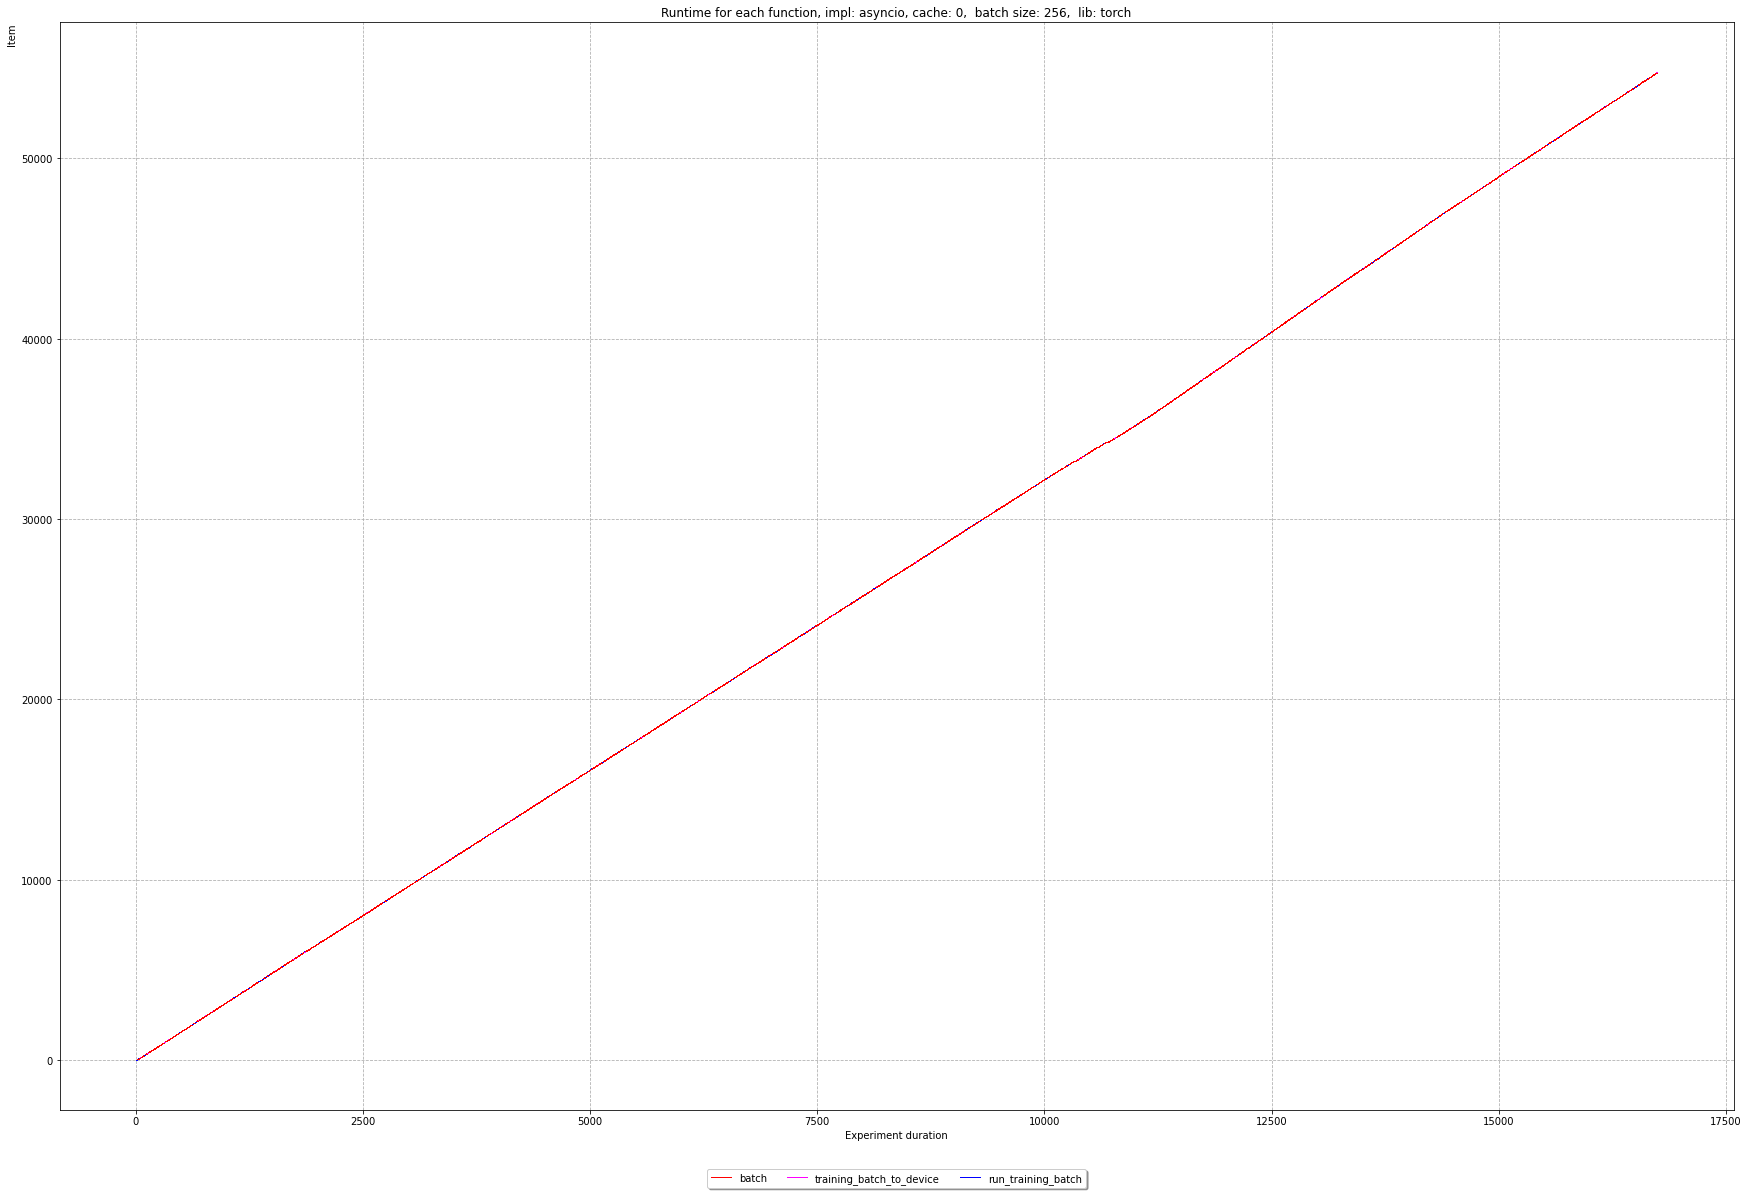

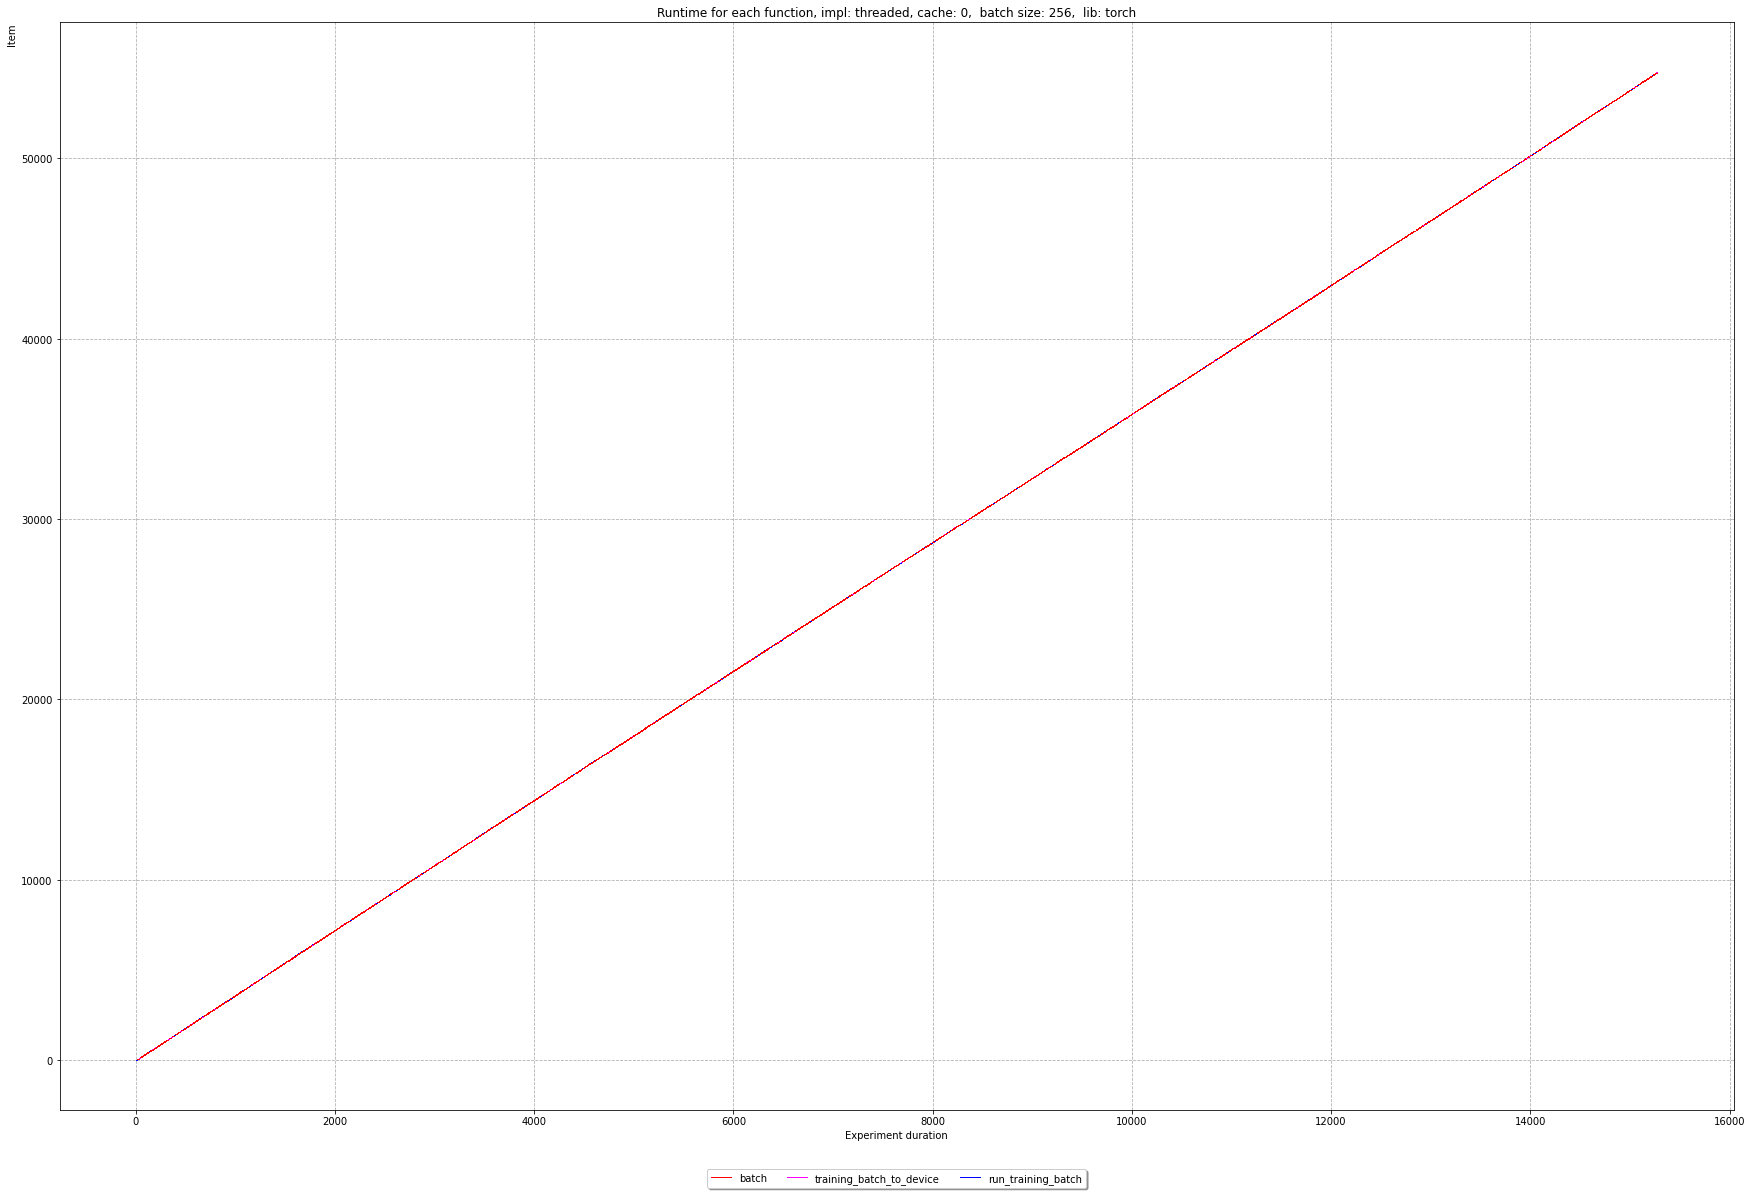

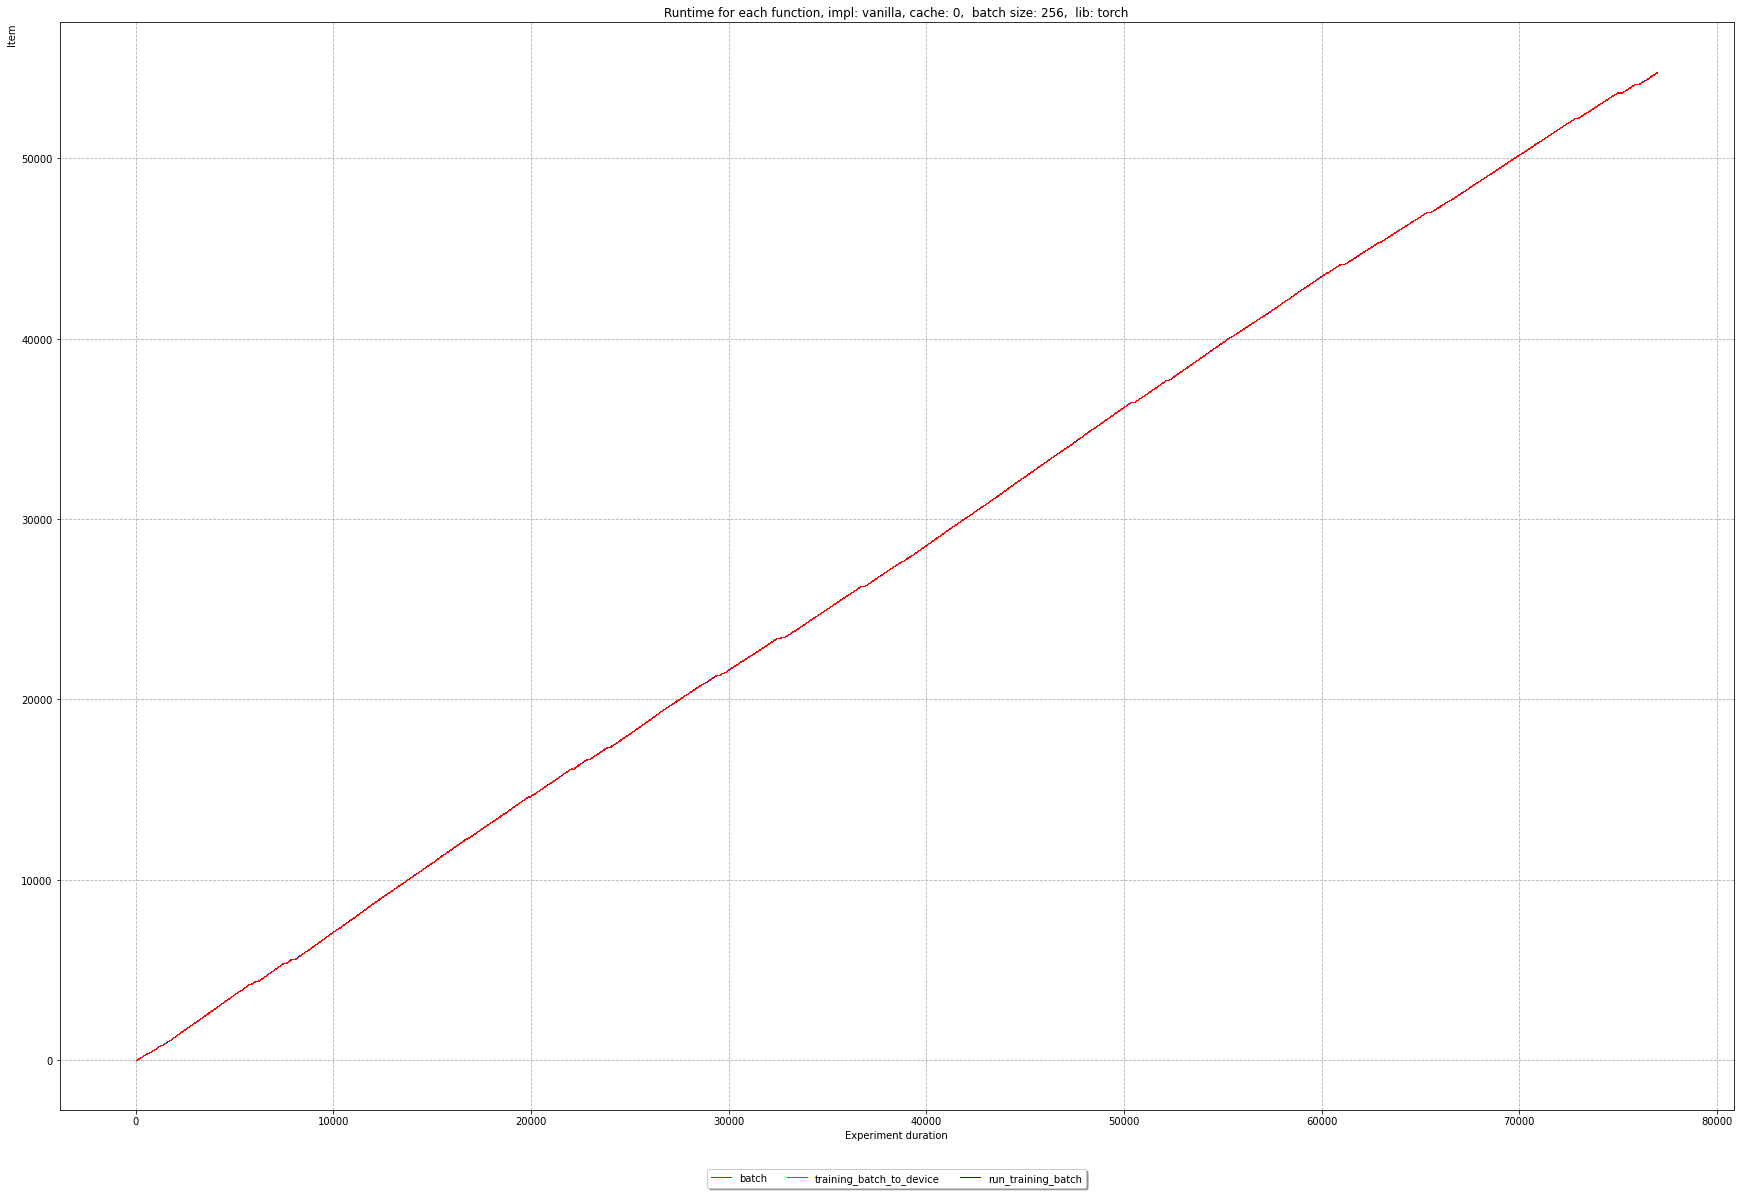

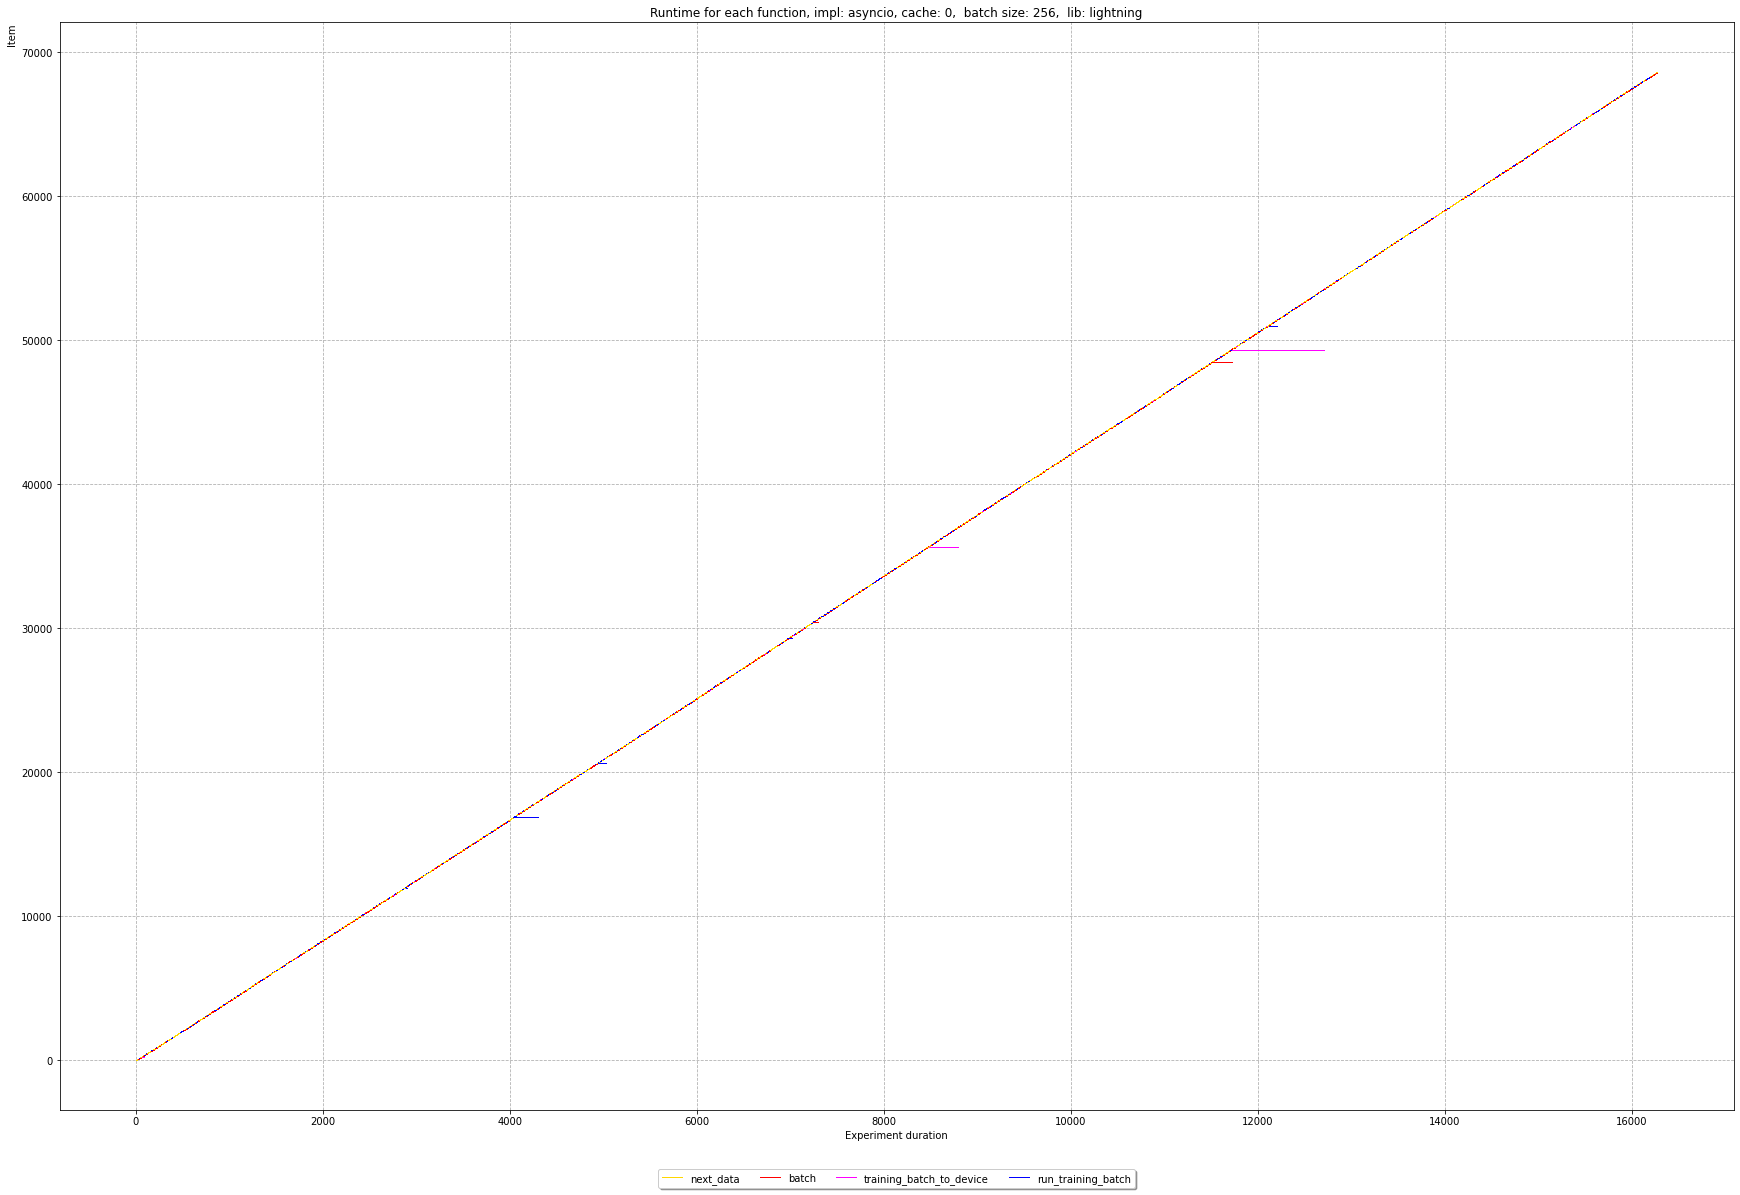

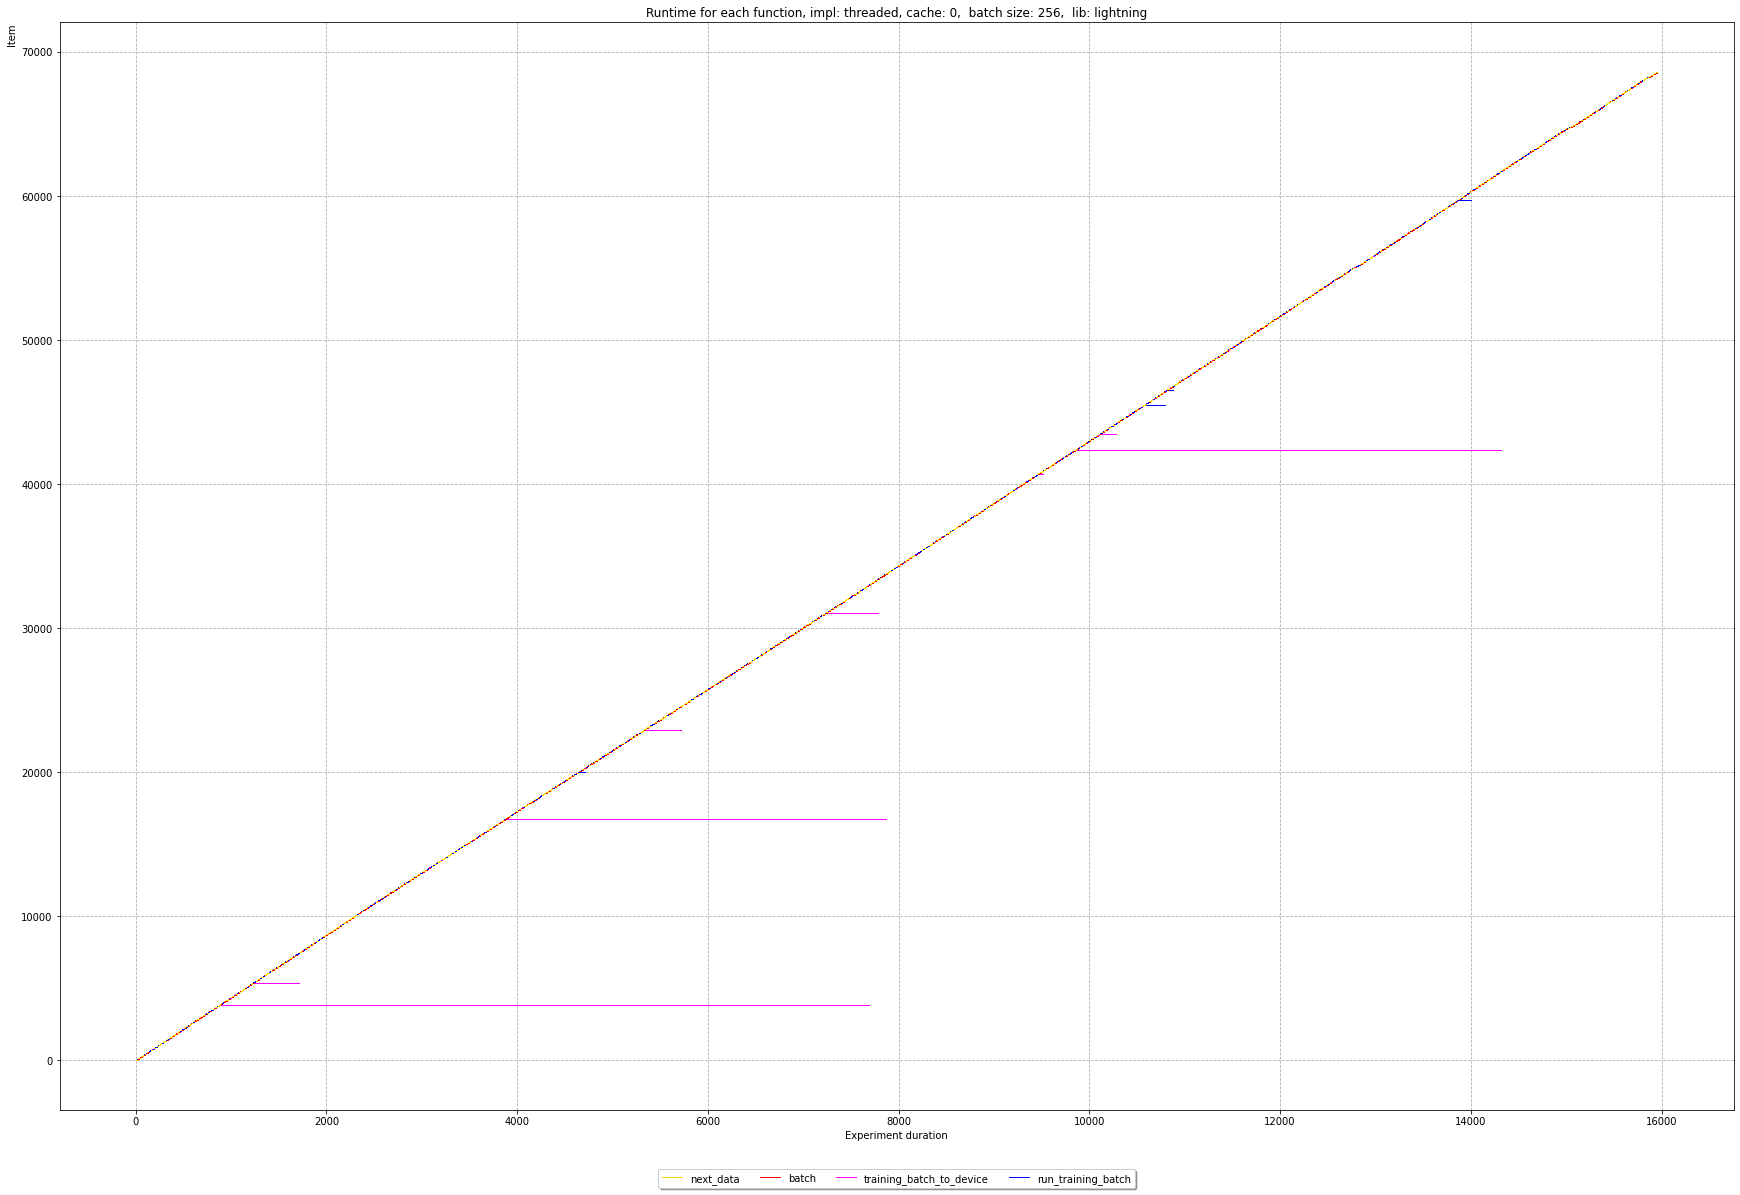

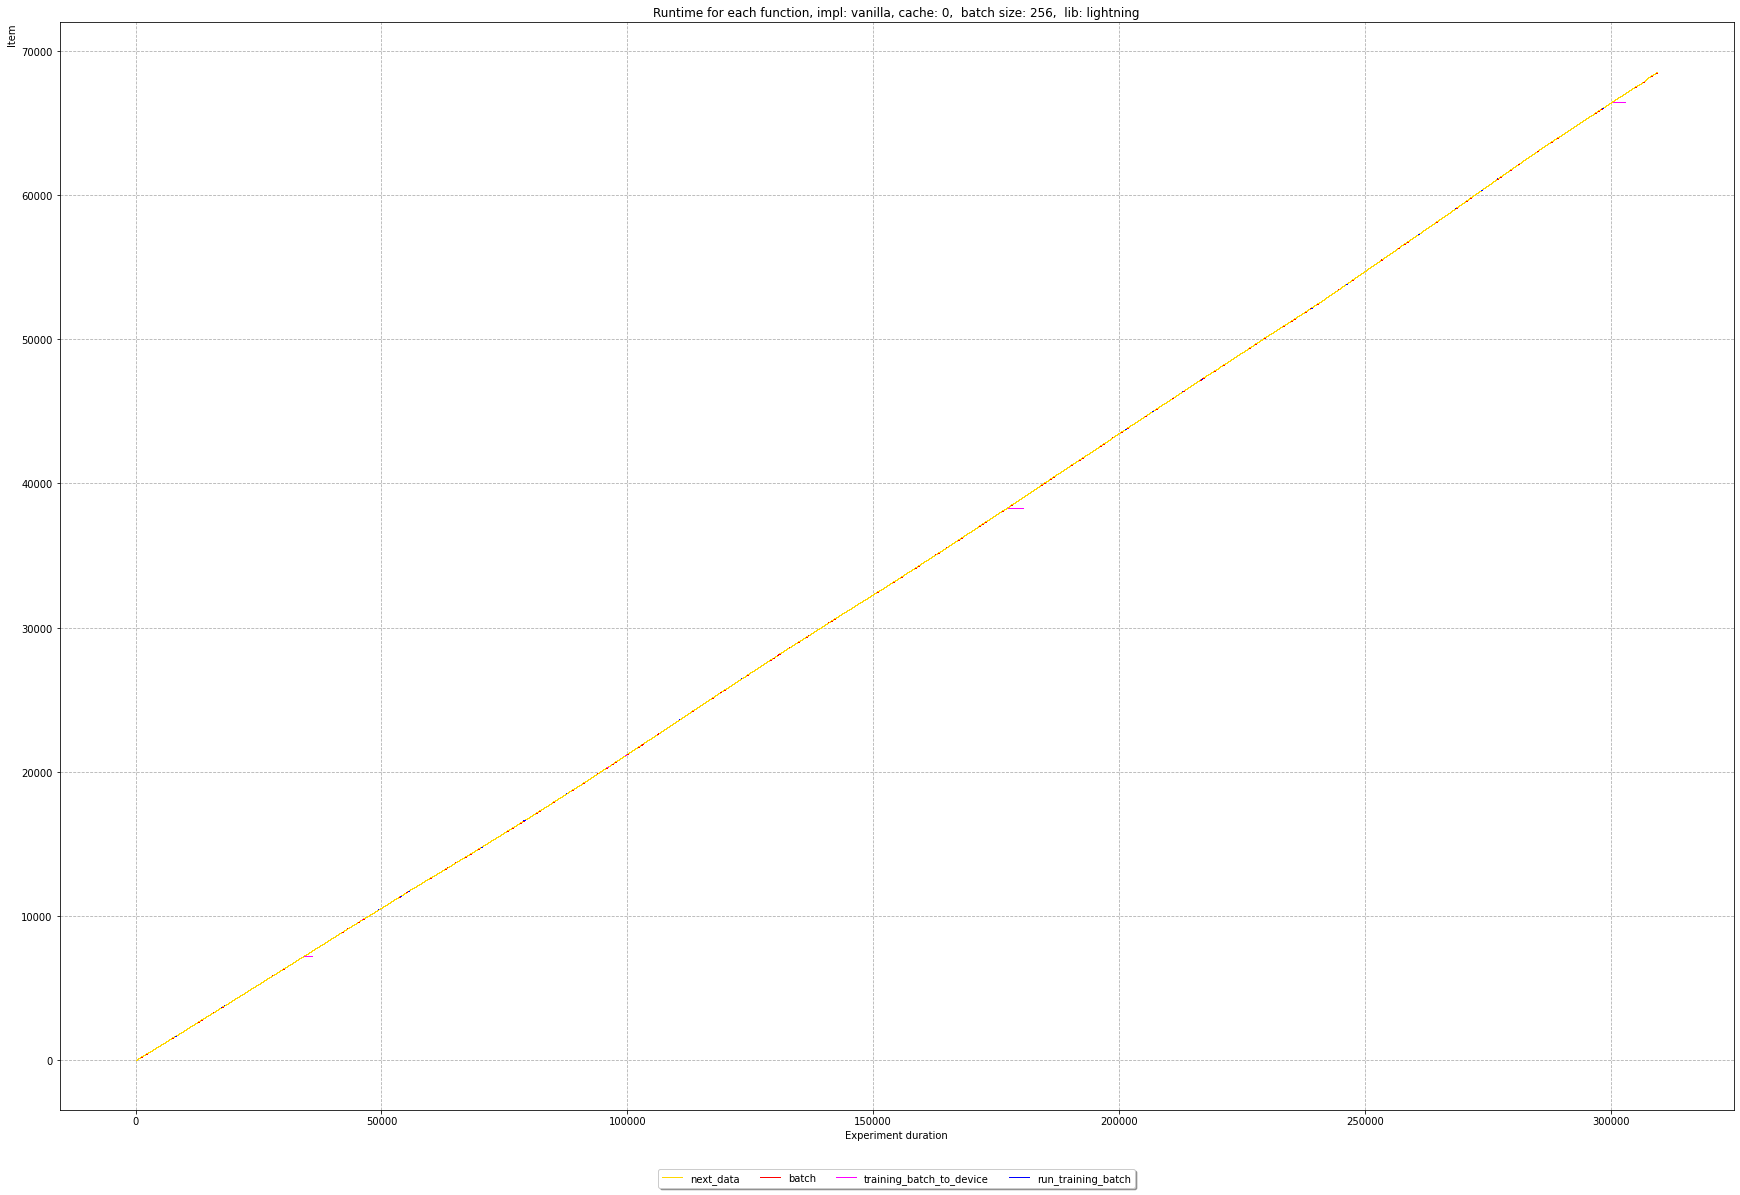

In [6]:
for implementation in ["torch", "lightning"]:
    for run in unique_runs_s3:
        if implementation in run:
            df = df_dataloader_s3[(df_dataloader_s3["run"]==run)]
            show_timelines(df, run, lanes, colors, False, False, 1)

### GPU Utilization

In [7]:
# Load the GPU utilization 
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:09<00:00, 214.66it/s]


In [8]:
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
print(unique_runs_s3)

['20220118f224612_benchmark_e2e_torch_s3_256_4_16_0_asyncio_sync'
 '20220119f032522_benchmark_e2e_lightning_s3_256_4_16_0_asyncio_sync'
 '20220119f075644_benchmark_e2e_torch_s3_256_4_16_0_threaded_sync'
 '20220119f121123_benchmark_e2e_lightning_s3_256_4_16_0_threaded_sync'
 '20220119f163729_benchmark_e2e_torch_s3_256_4_16_0_vanilla_sync'
 '20220121f082622_benchmark_e2e_lightning_s3_256_4_16_0_vanilla_sync']


71.35897435897436 41.45205479452055


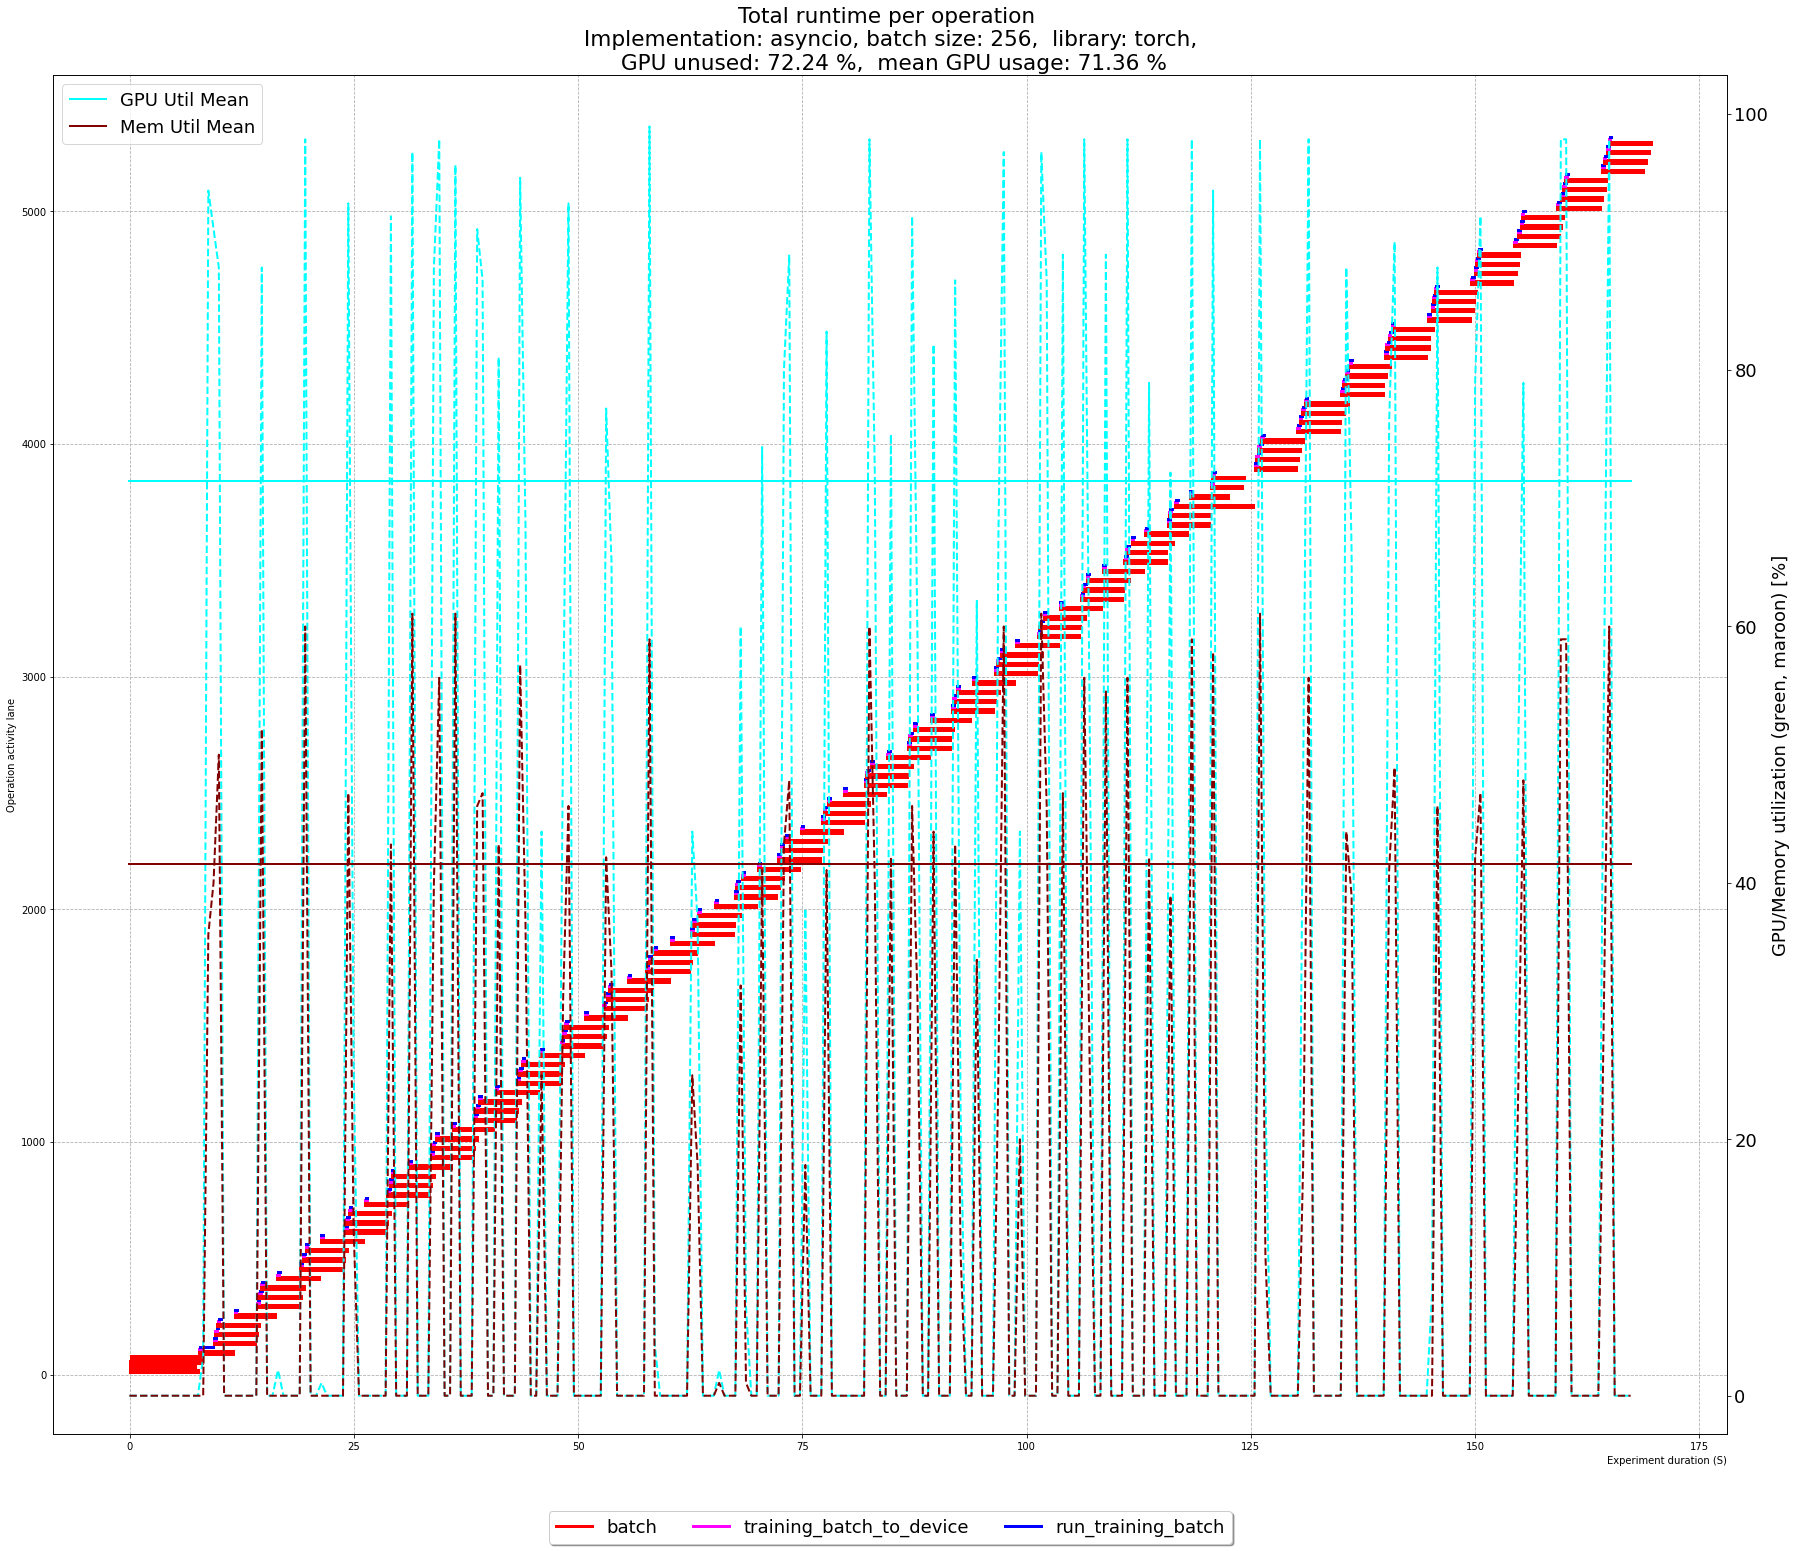

48.291666666666664 20.81578947368421


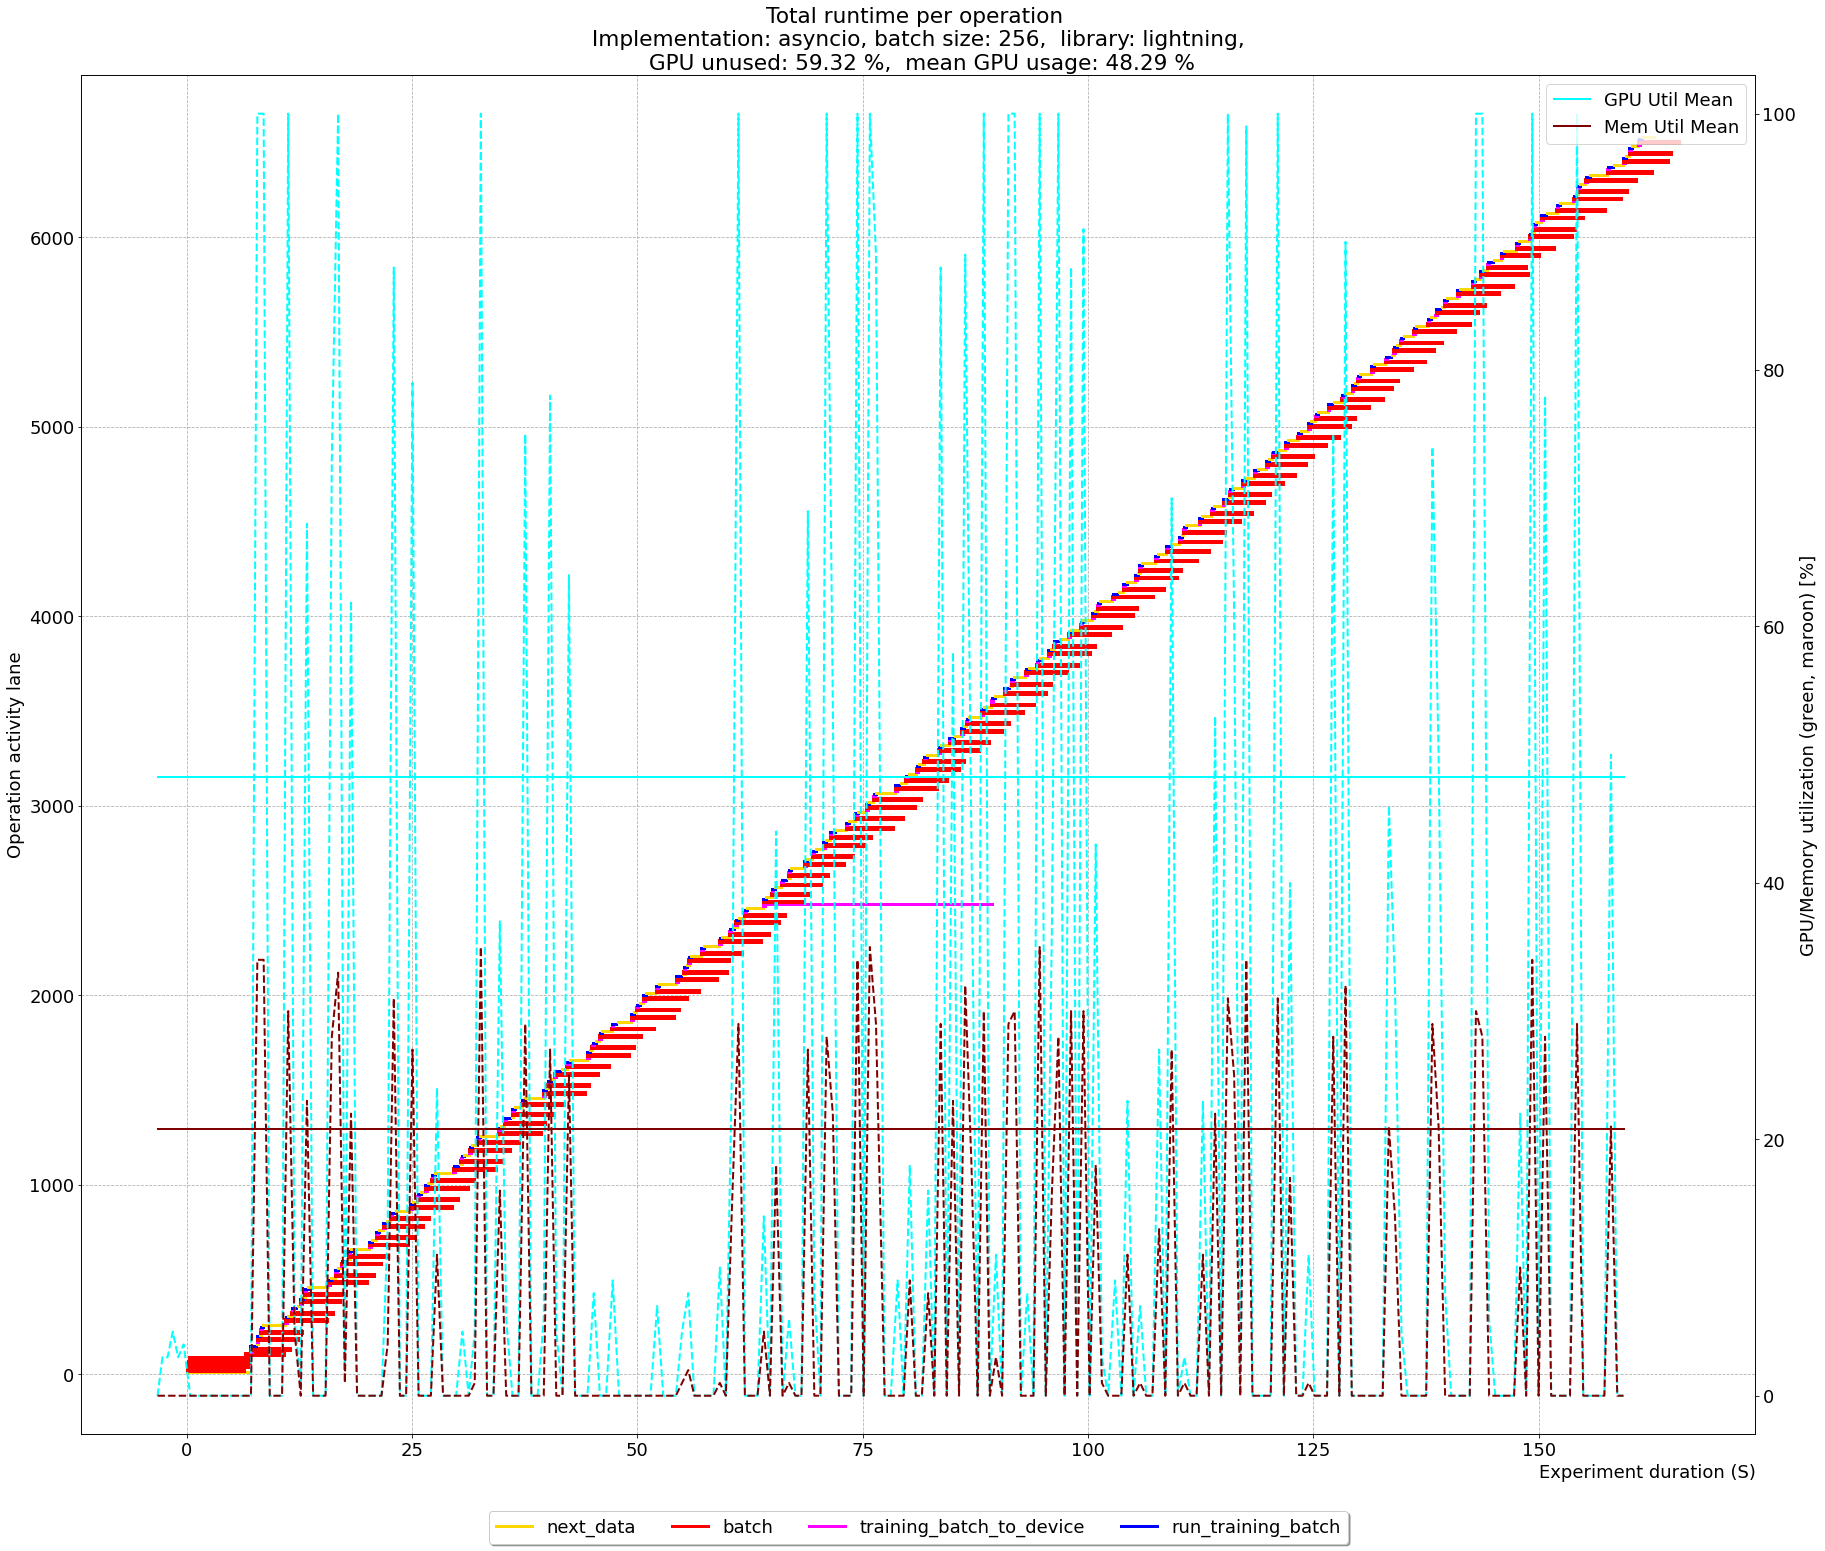

59.06060606060606 35.5


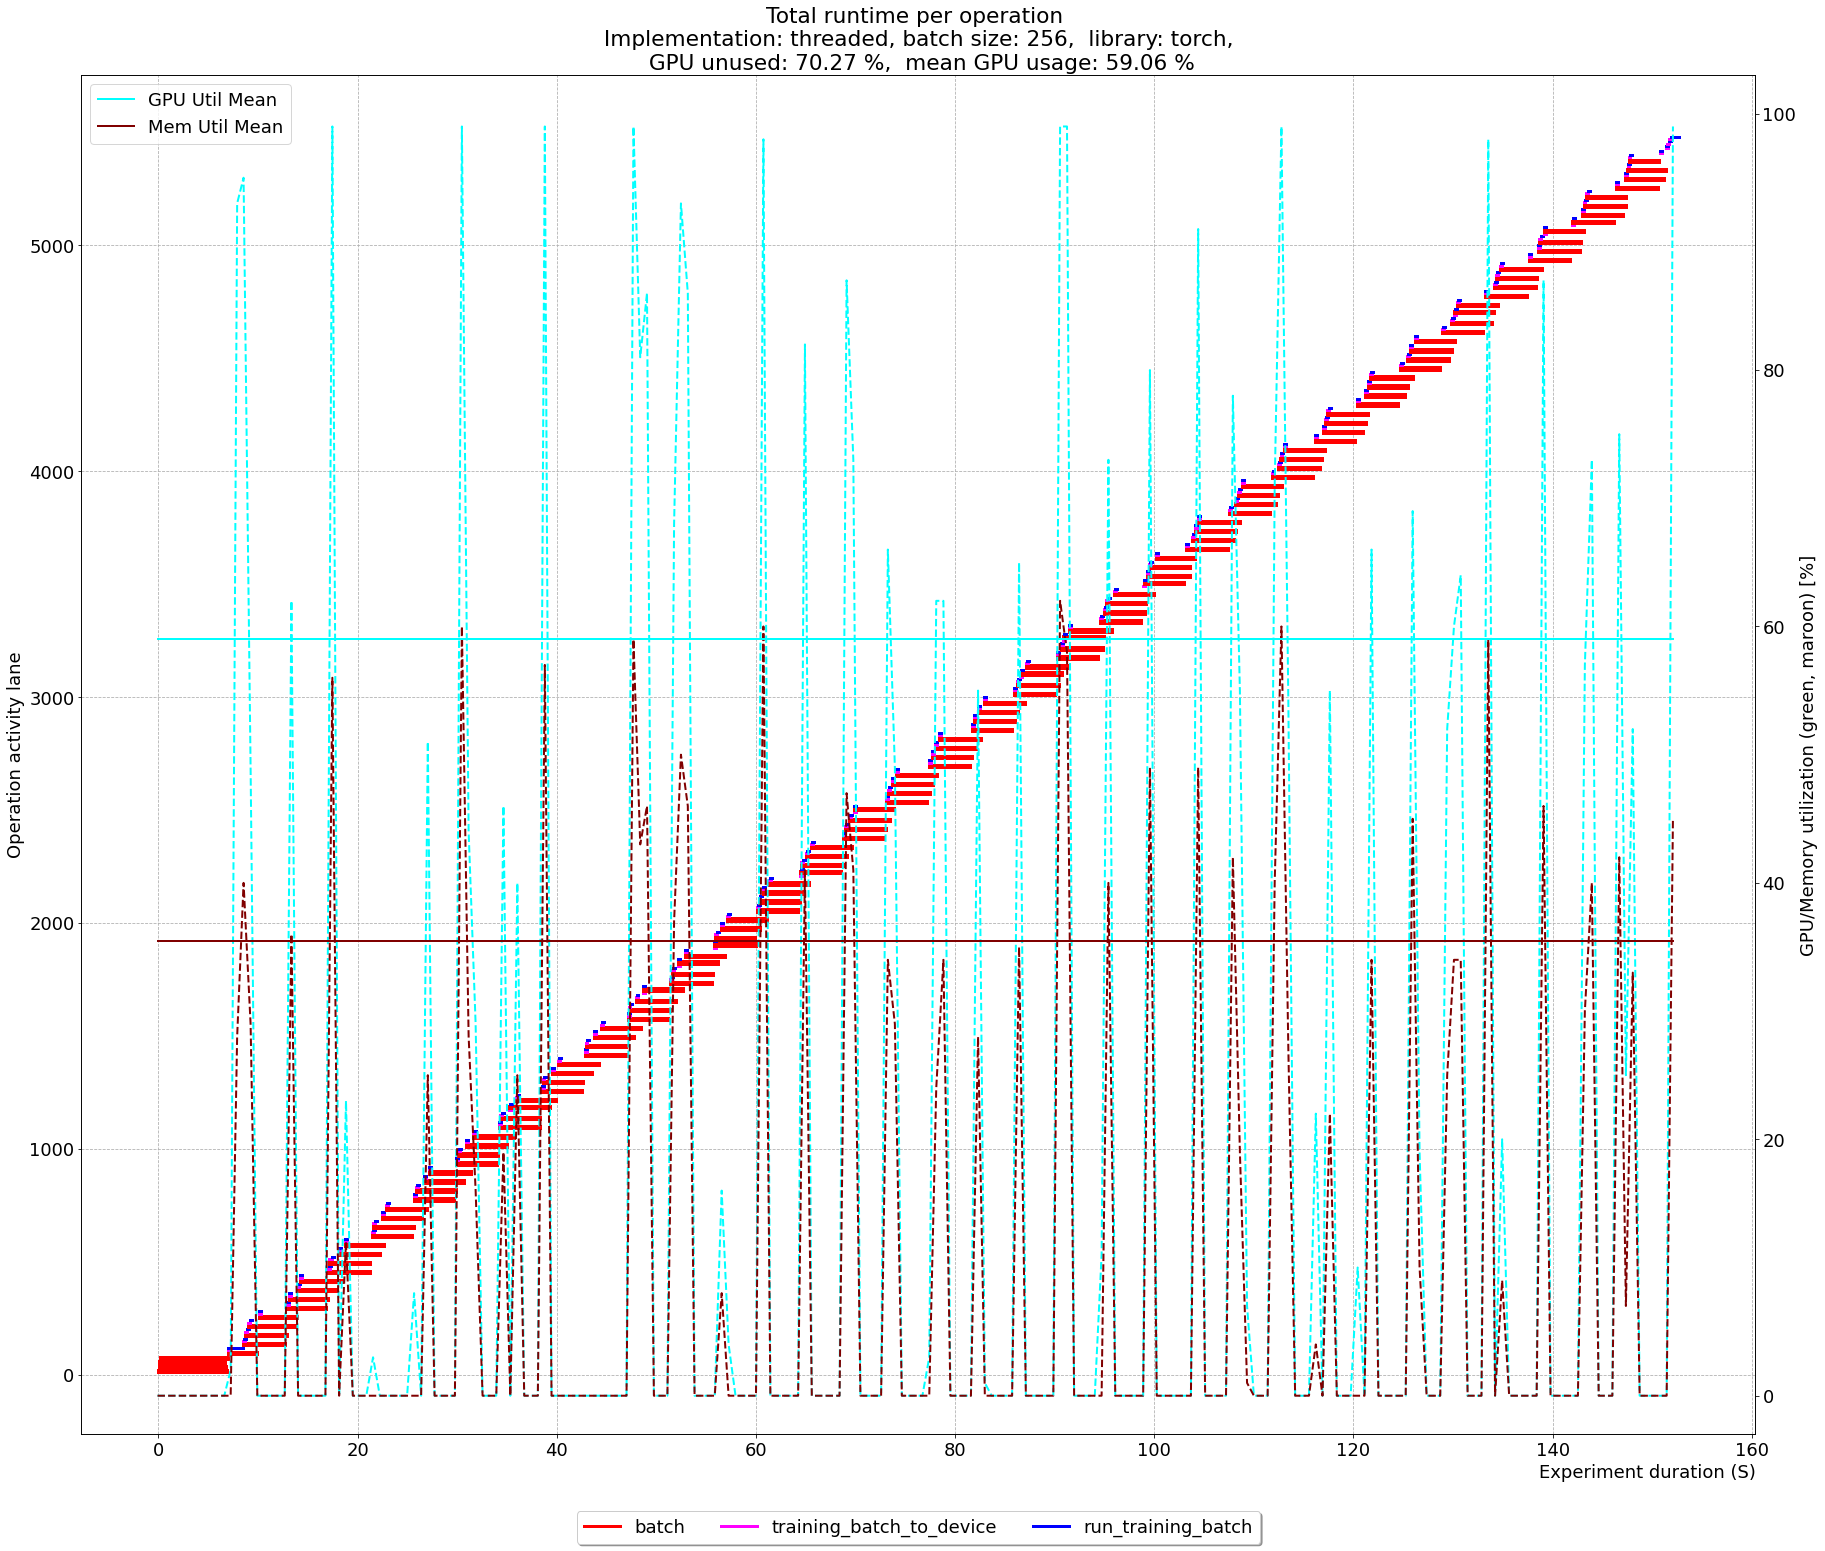

59.96190476190476 24.568181818181817


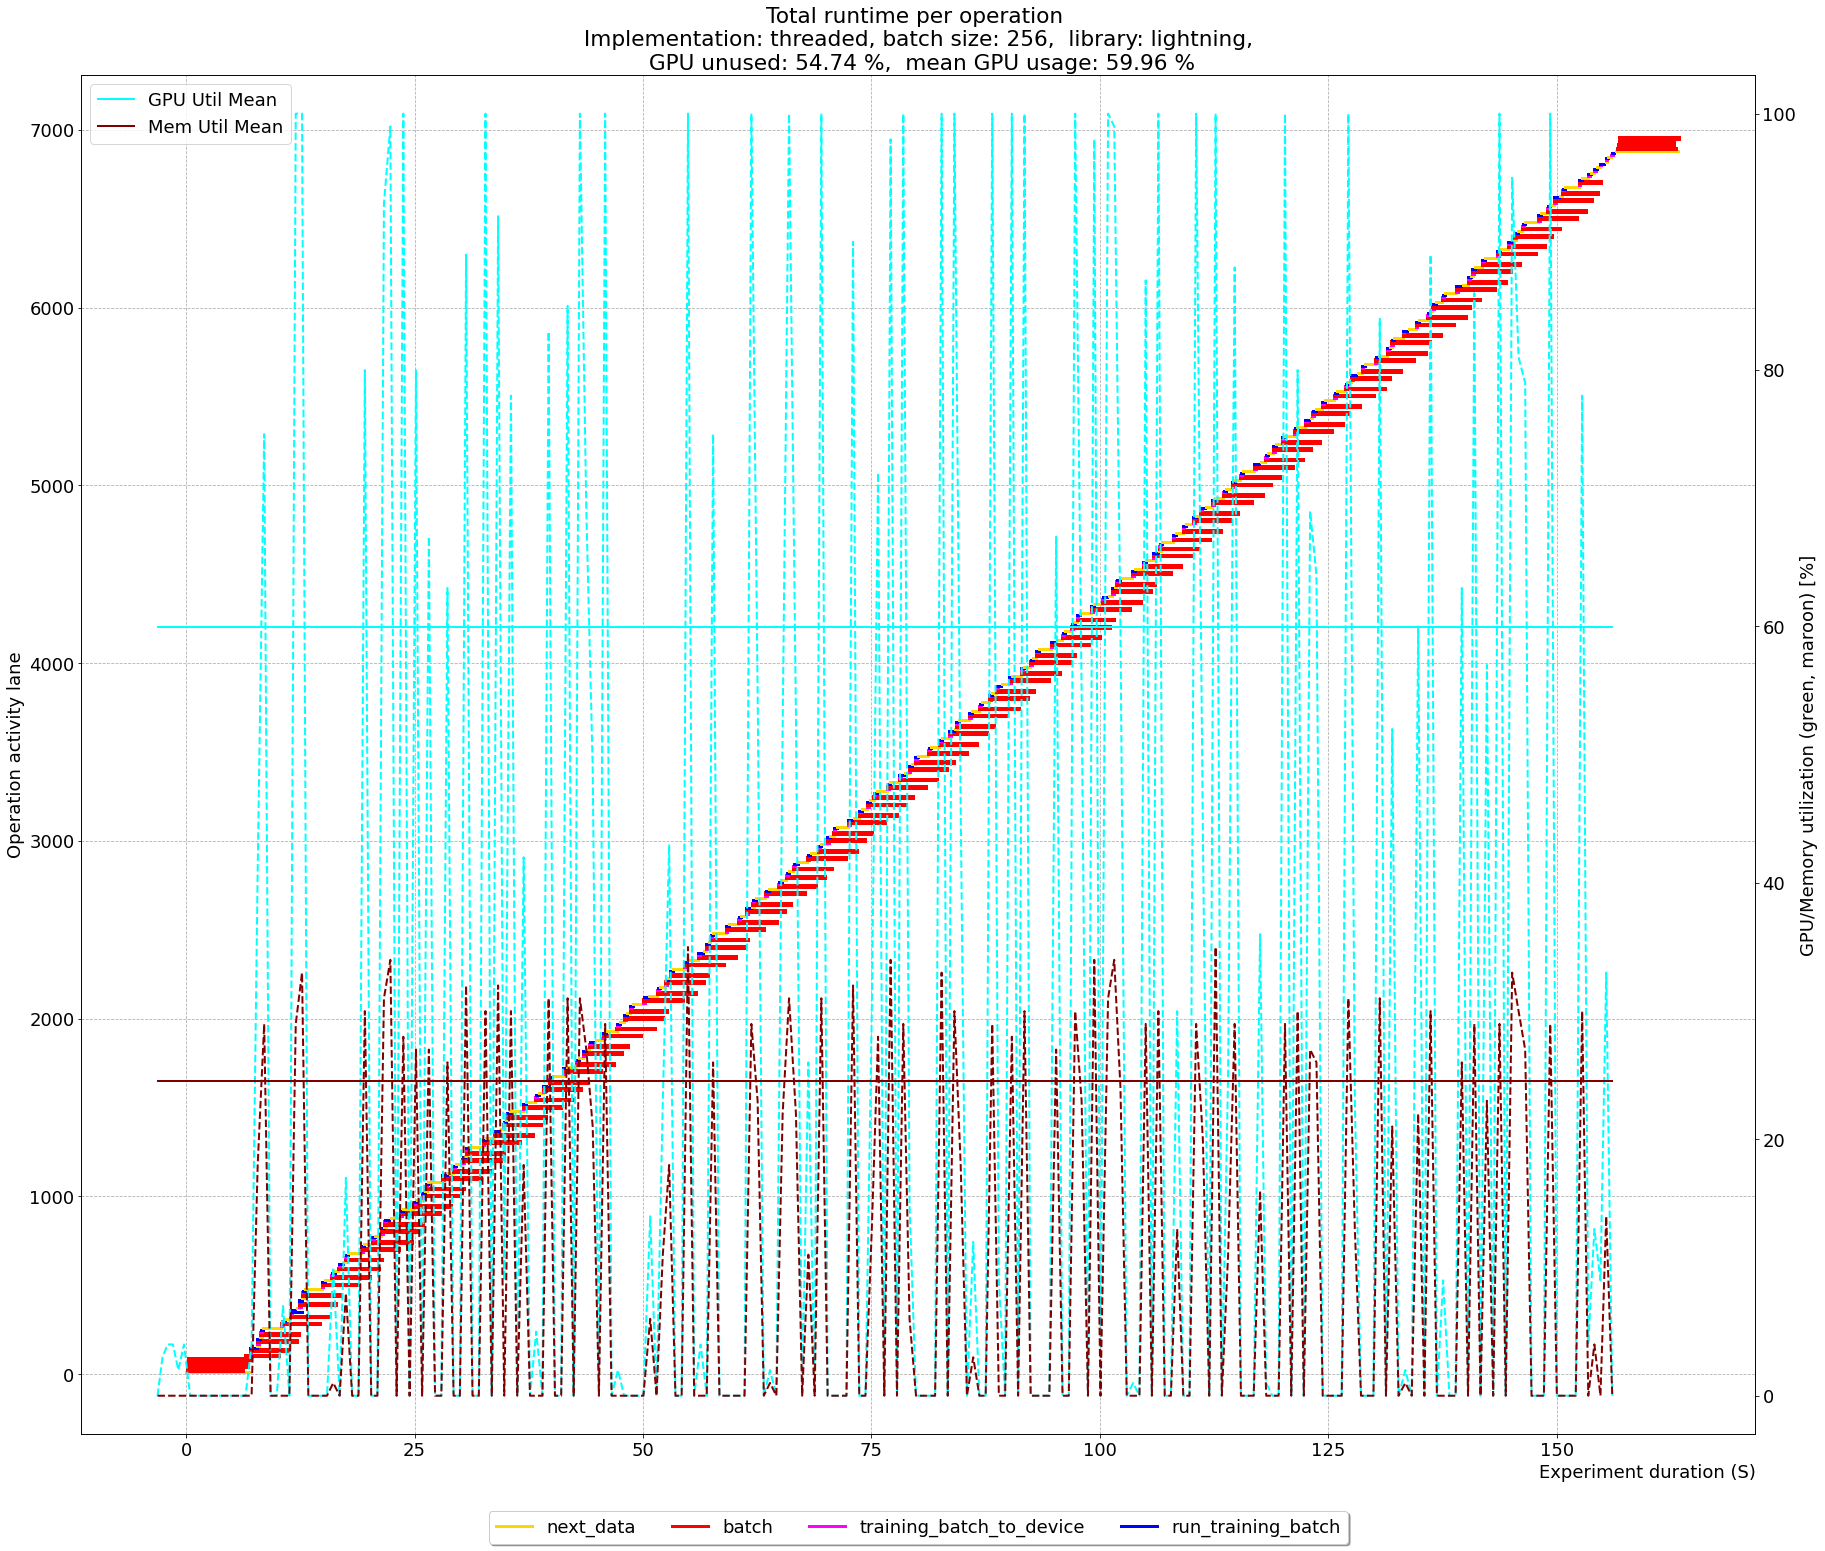

66.08196721311475 39.6140350877193


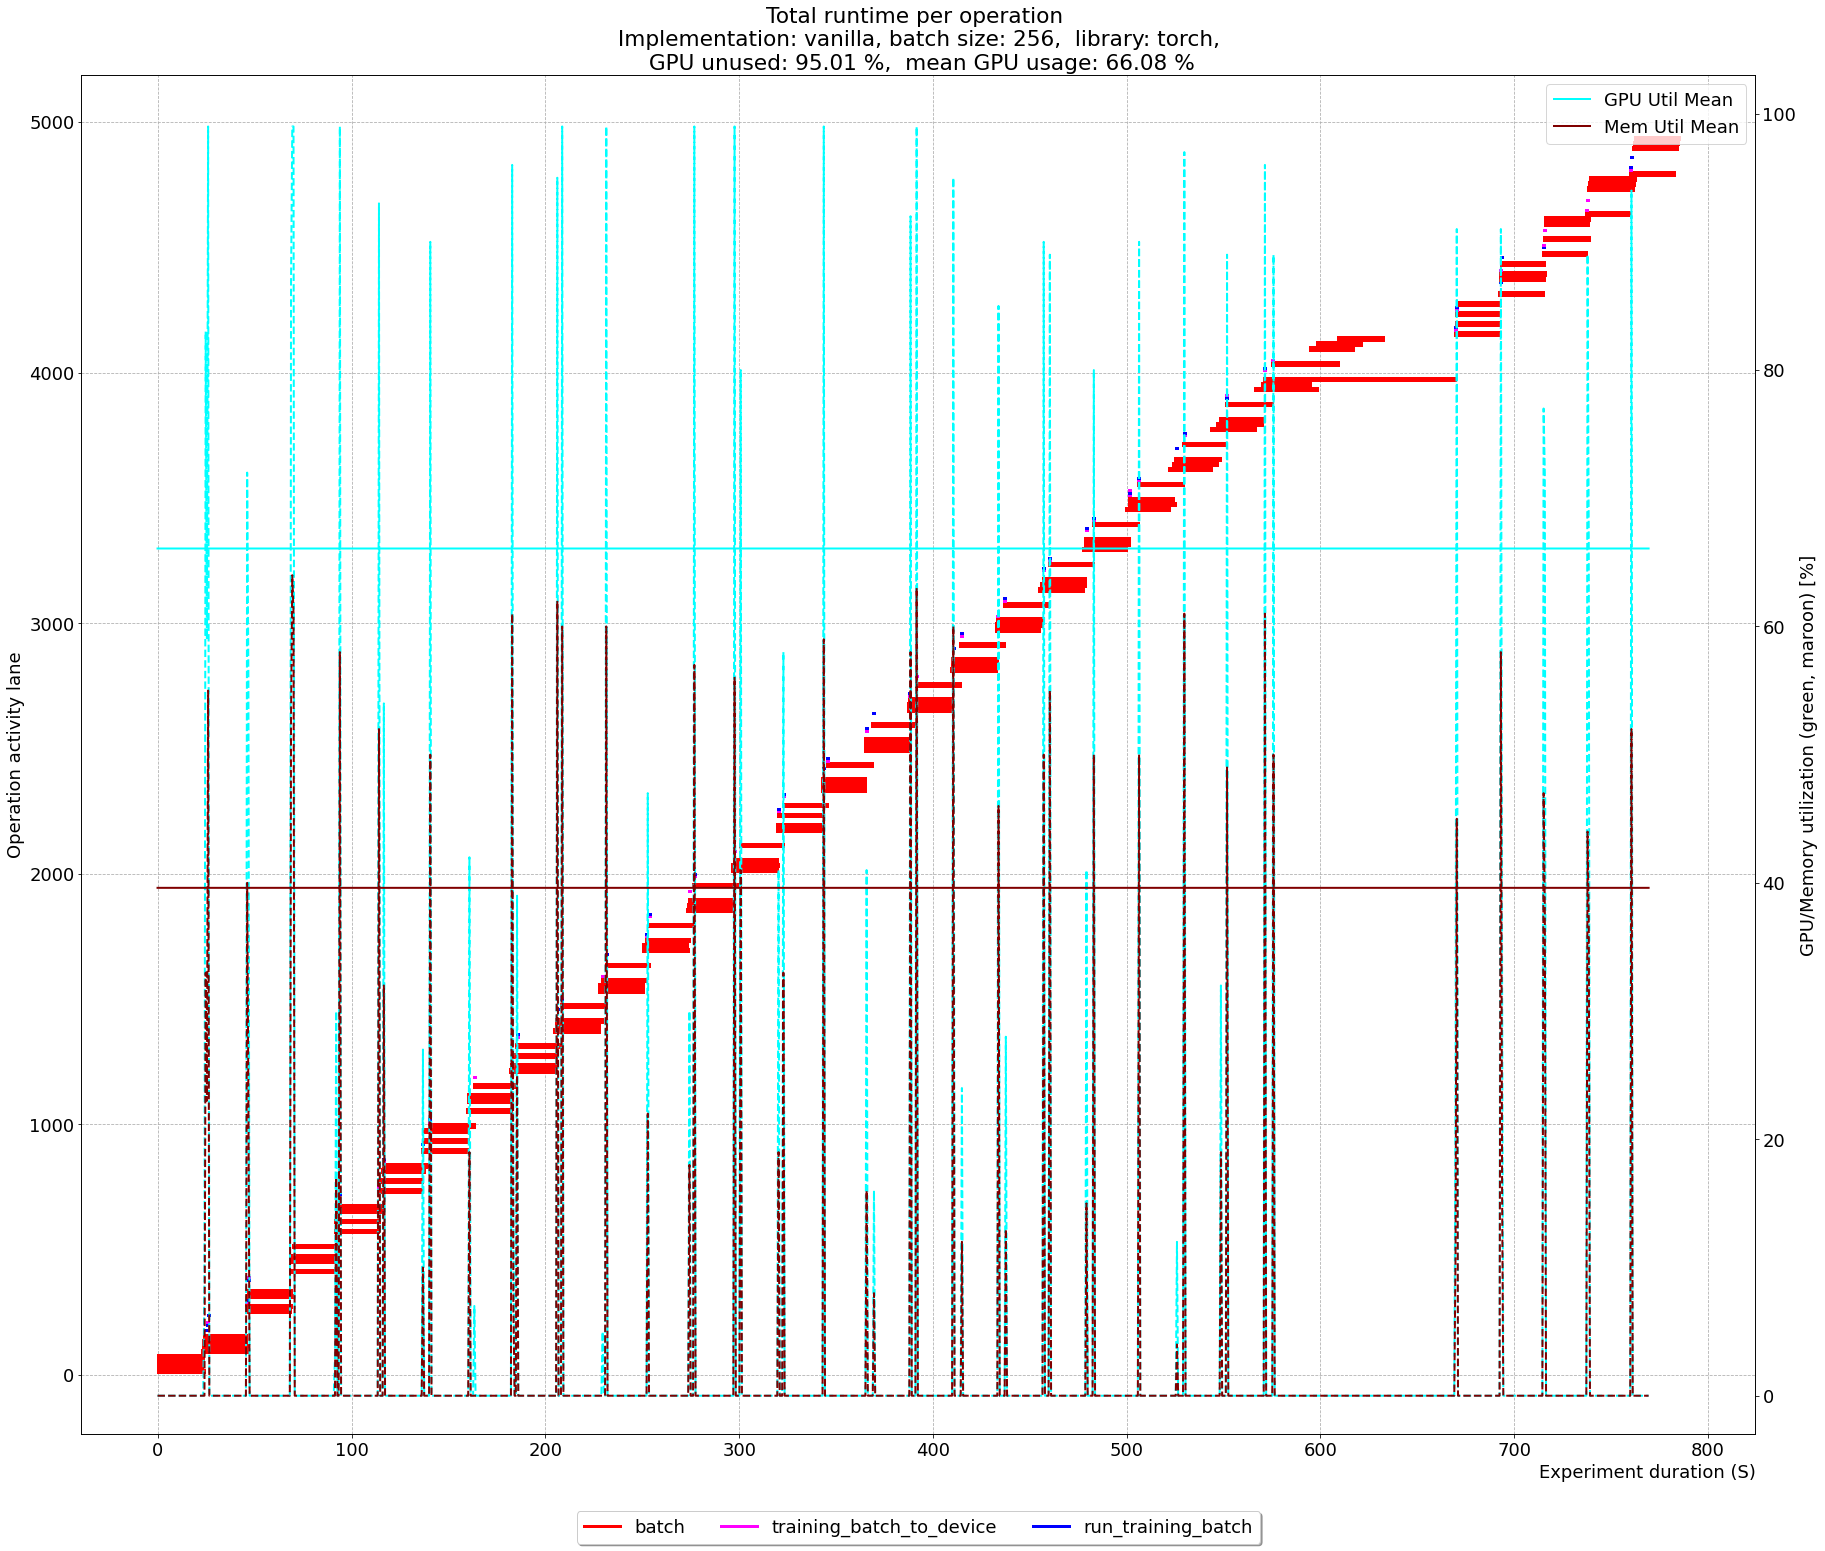

54.96638655462185 22.161616161616163


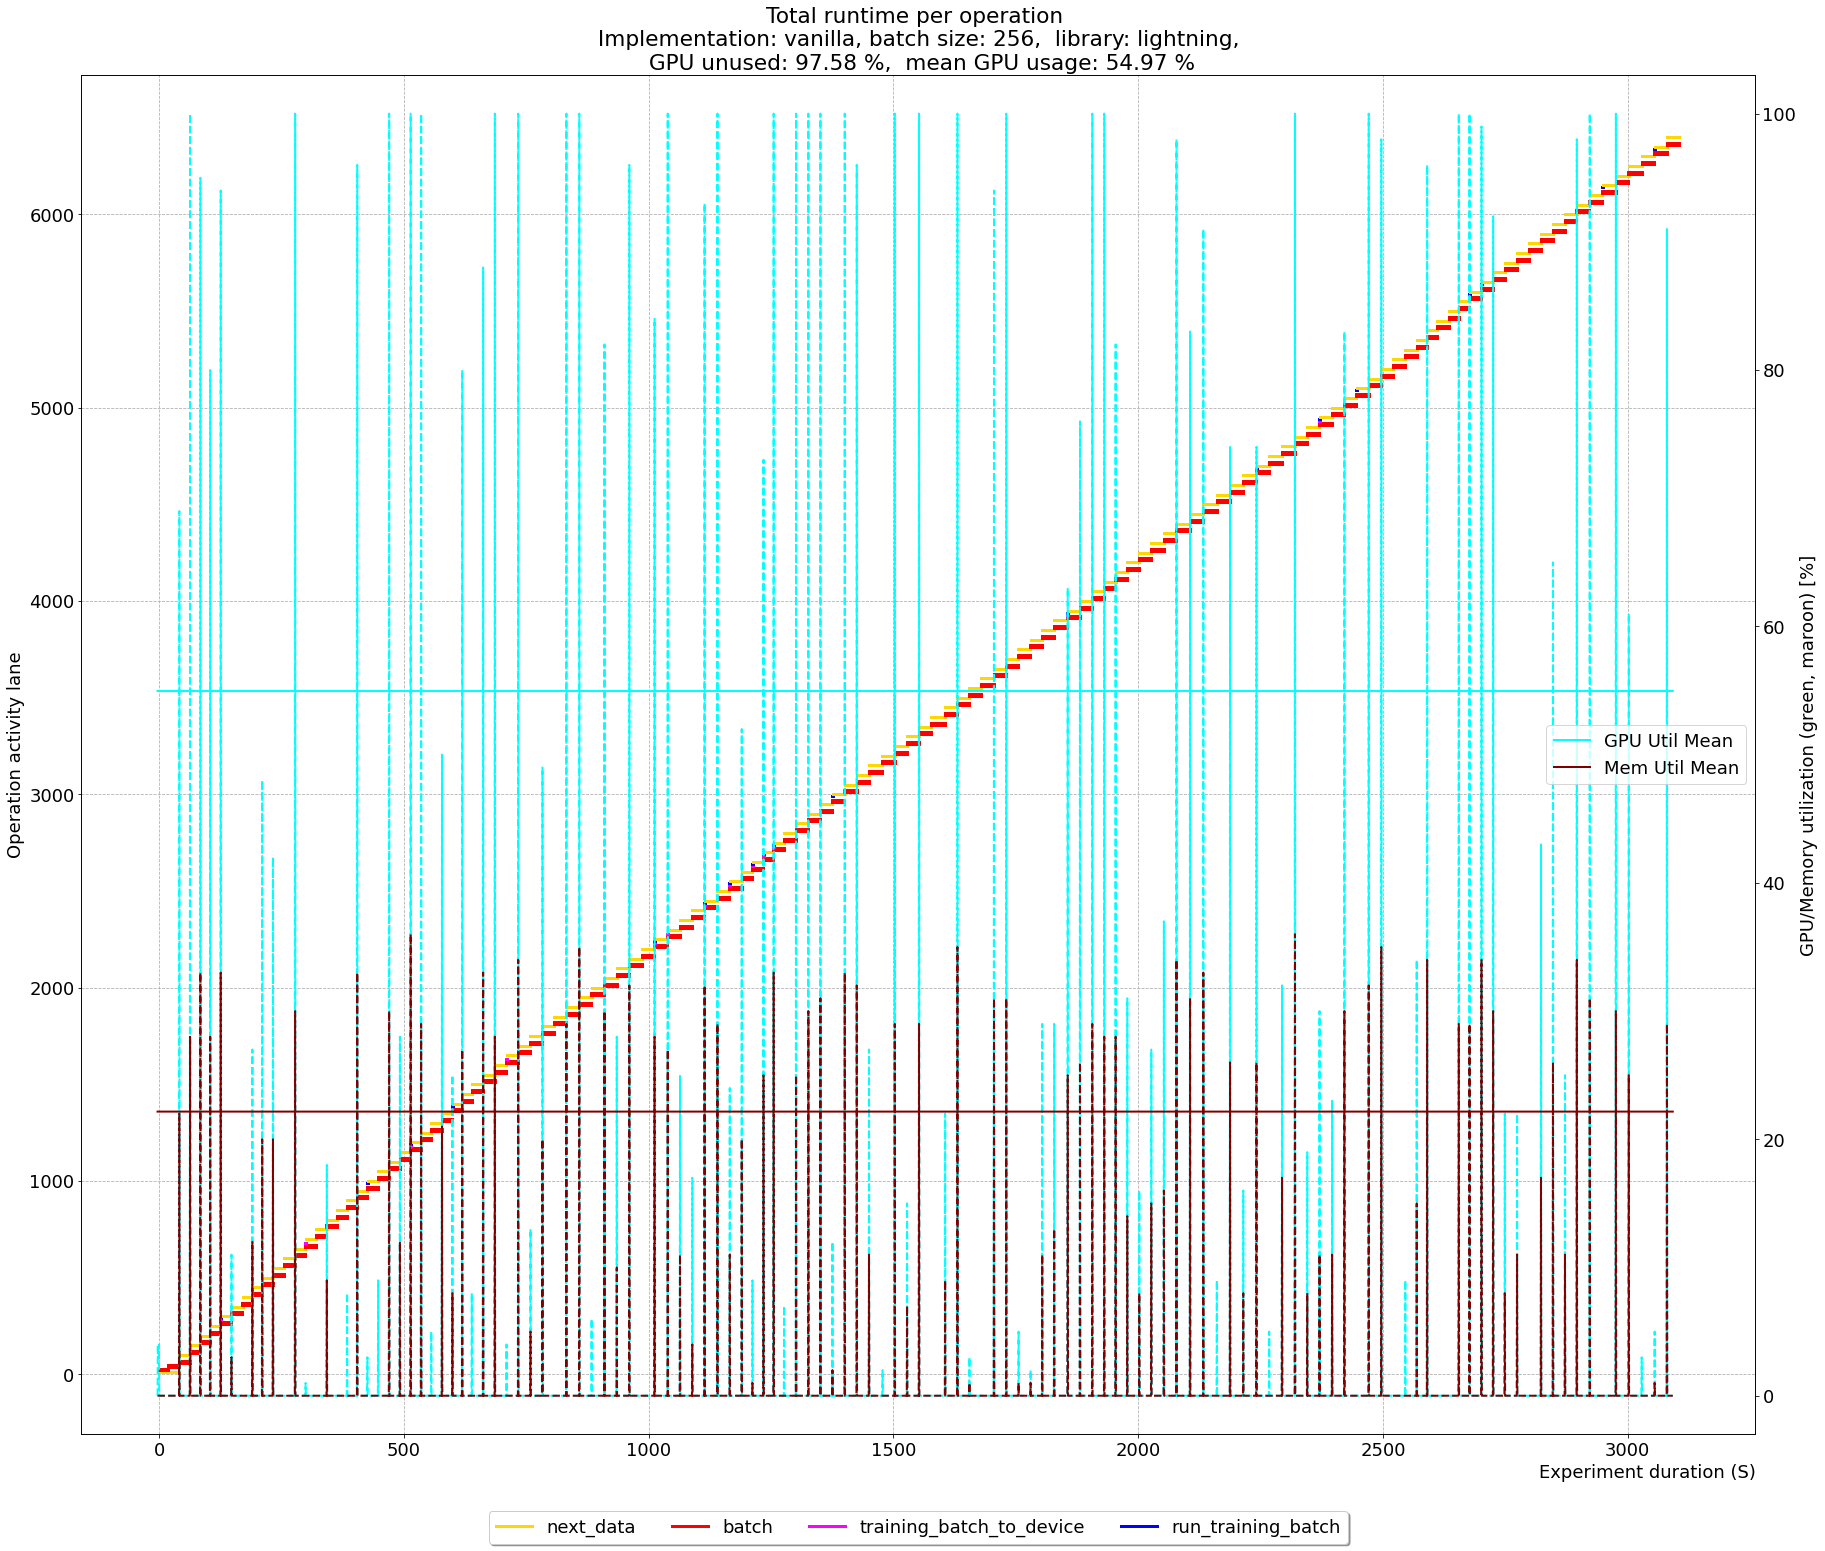

In [9]:
returns_s3 = []
for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    returns_s3.append(show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, True, 0.2, "0"))

### Result tables

The following two tables display throughput details for both experiments. The default sample size, i.e. number of dataset items is 3000.

In [10]:
samples = 35000

In [11]:
# S3
results = pd.DataFrame.from_records(data=returns_s3)
results["throughput"] = samples / results["runtime"]
results.sort_values(["runtime", "library"], ascending=True)

runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
2   15276.229050      70.270270               59.060606       9.274775   
3   15957.507309      54.741379               59.961905       9.318966   
1   16272.777470      59.322034               48.291667       6.703390   
0   16746.884438      72.241993               71.358974      10.768683   
4   76987.910204      95.012265               66.081967       1.846280   
5  309552.717990      97.584737               54.966387       0.445301   

   mem_util_mean_no_zeros implementation cache    library  throughput  
2               35.500000       threaded     0      torch    2.291141  
3               24.568182       threaded     0  lightning    2.193325  
1               20.815789        asyncio     0  lightning    2.150831  
0               41.452055        asyncio     0      torch    2.089941  
4               39.614035        vanilla     0      torch    0.454617  
5               22.161616        vanilla     0  lightning    0.113066

In [12]:
impls = ["threaded", "asyncio", "vanilla"]
libs = ["torch", "lightning"]

In [13]:
# since the experiment was not repeated, there is not array of values to plot in violin
# so here is a not-so-clever workaround 

df = pd.DataFrame()
def add_stats(row):
    line = [row["throughput"]] * 3
    line.append(0.0)
    line.append(0.0)
    new_row = pd.DataFrame([pd.Series(line)], index = [row["implementation"] + "_" + row["library"]])
    return df.append(new_row)

# add to df
for index, row in results.iterrows():
    df = add_stats(row)

# give names
df.columns = [0, 1, "mean", "std_dev", "var"]

In [14]:
df

0         1      mean  std_dev  var
asyncio_torch       2.089941  2.089941  2.089941      0.0  0.0
asyncio_lightning   2.150831  2.150831  2.150831      0.0  0.0
threaded_torch      2.291141  2.291141  2.291141      0.0  0.0
threaded_lightning  2.193325  2.193325  2.193325      0.0  0.0
vanilla_torch       0.454617  0.454617  0.454617      0.0  0.0
vanilla_lightning   0.113066  0.113066  0.113066      0.0  0.0

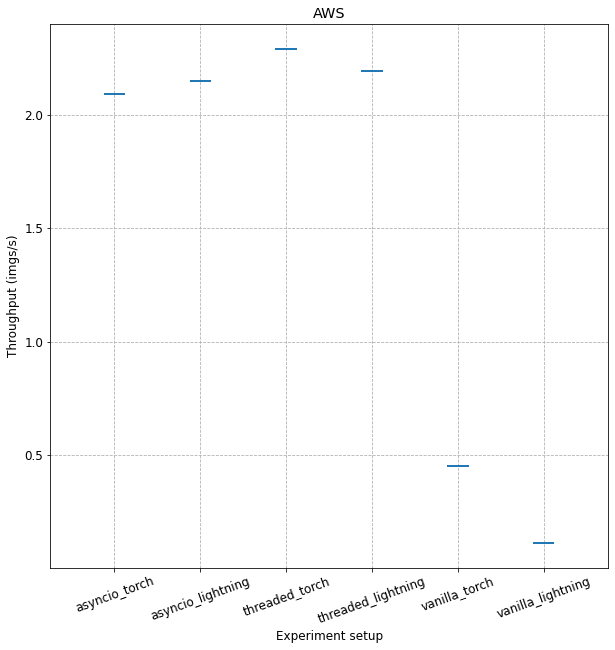

In [16]:
plot_violins(df, "AWS") # 